In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %%
import math
import random

import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import numpy as np
from sae.sae import SAE
from sae.sae_config import SAEConfig, MultiDimSAEConfig
from sae.multi_dim_sae import MultiDimSAE
from utils.embeddings import (
    sample_embeddings,
    sample_embeddings_independently,
    generate_feature_embeddings,
)
from tqdm import tqdm
from utils.embeddings import centered_embeddings

torch.manual_seed(0)
random.seed(0)

### Random Features Model

- We sample 20 dimensional linear features and 2 dimensional features from a circle.
- All the features are shifted by a common bias term.
- Each feature is treated as a IID binomial random variable.

The linear features can be orthonalised to the 2D features.

In [3]:
# %%

num_linear_features = 100
d_in = 20
num_multi_dim_features = 100
orthogonalize_coefficient = 1.0  # 0.85

linear_feature_embeddings = torch.randn(num_linear_features, d_in)

In [4]:
# %%
# Call the function
embeddings = generate_feature_embeddings(
    num_multi_dim_features, d_in, num_linear_features, orthogonalize_coefficient
)

linear_feature_embeddings = embeddings["linear_feature_embeddings"]
multi_dim_feature_embeddings = embeddings["multi_dim_feature_embeddings"]
common_bias = embeddings["bias"]


print(torch.linalg.matrix_rank(linear_feature_embeddings))

tensor(18)


In [5]:
# %%
# show dotproduct between multi_dim_feature_embeddings and linear_feature_embeddings
# from utils.plotter import desc_embeddings

# desc_embeddings(linear_feature_embeddings, multi_dim_feature_embeddings)

print(linear_feature_embeddings.norm(dim=1).mean().item())
print(multi_dim_feature_embeddings.norm(dim=1).mean().item())

with centered_embeddings(
    bias=common_bias,
    linear_feature_embeddings=linear_feature_embeddings,
    multi_dim_feature_embeddings=multi_dim_feature_embeddings,
):
    print(linear_feature_embeddings.norm(dim=1).mean().item())
    print(multi_dim_feature_embeddings.norm(dim=1).mean().item())

print(linear_feature_embeddings.norm(dim=1).mean().item())
print(multi_dim_feature_embeddings.norm(dim=1).mean().item())



1.000647783279419
1.0001016855239868
1.0
1.0
1.000647783279419
1.0001016855239868


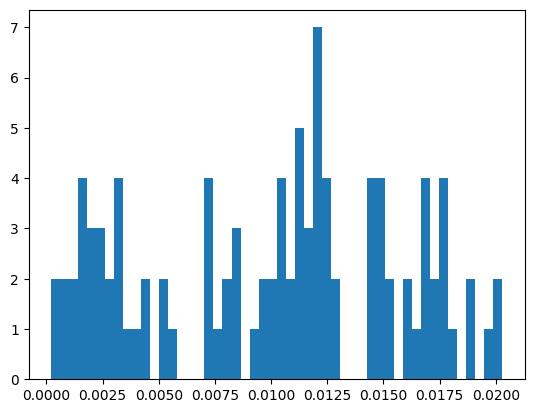

In [6]:
# %%

linear_feature_freqs = torch.rand(num_linear_features)
linear_feature_freqs /= linear_feature_freqs.sum(dim=0)
plt.hist(linear_feature_freqs.numpy(), bins=50)
plt.show()
multi_dim_feature_freqs = torch.ones(num_multi_dim_features)
multi_dim_feature_freqs /= multi_dim_feature_freqs.sum(dim=0)
# plt.plot(multi_dim_feature_freqs.numpy())

# linear_exists_prob = 0.6
# multi_dim_exists_prob = 0.5



In [7]:
# %%
# dataset = [
#     sample_embeddings(
#         linear_feature_embeddings,
#         multi_dim_feature_embeddings,
#         linear_feature_freqs,
#         multi_dim_feature_freqs,
#         linear_exists_prob,
#         multi_dim_exists_prob,
#     )
#     for _ in range(10000)
# ]
embeddings_dataset = [
    sample_embeddings_independently(
        linear_feature_embeddings,
        multi_dim_feature_embeddings,
        linear_feature_freqs,
        multi_dim_feature_freqs,
        max_linear_features=1,
        max_multi_dim_features=1,
    )
    for _ in tqdm(range(10000))
]

# make a dataset out of it
labels = [d["label"] for d in embeddings_dataset]
dataset = torch.stack([d["x"] for d in embeddings_dataset])


concatenated_labels = torch.stack([torch.cat(label) for label in labels])
print(concatenated_labels.sum(dim=1).mean().item(), concatenated_labels.shape)



100%|██████████| 10000/10000 [00:09<00:00, 1064.08it/s]

1.2725000381469727 torch.Size([10000, 200])


In [8]:
# %%


# torch.autograd.detect_anomaly(check_nan=True)

m_config = SAEConfig(
    input_dim=20,
    latent_dim=400,
    l1_weight=0.1,
    activation_fn=F.relu,
    learning_rate=0.001,
    multi_dim_config=MultiDimSAEConfig(num_multi_dim_features=100),
)

m_sae = MultiDimSAE(m_config)


# for n, p in m_sae.named_parameters():
#     print(n, torch.isnan(p).float().mean().item())


m_sae.train_model(dataset, num_epochs=1000)

# for n, p in m_sae.named_parameters():
# print(n, torch.isnan(p).float().mean().item())

100%|██████████| 1000/1000 [00:28<00:00, 35.31it/s]


MultiDimSAE()

In [9]:
# %%
# m_sae.plot_losses()

In [10]:
# %%
config = SAEConfig(
    input_dim=d_in,
    latent_dim=500,
    l1_weight=0.01,
    activation_fn=F.relu,
    learning_rate=0.001,
)
sae = SAE(config).train_model(dataset, num_epochs=1000)

100%|██████████| 1000/1000 [00:19<00:00, 52.21it/s]


In [11]:
# %%
sae.plot_losses()



In [12]:
# %%
labels_l0_norm = (concatenated_labels > 0).float().sum(dim=1).mean().item()

print(labels_l0_norm, sae.logs["l0_norm"].to_numpy()[-1])


1.2725000381469727 21.77589988708496


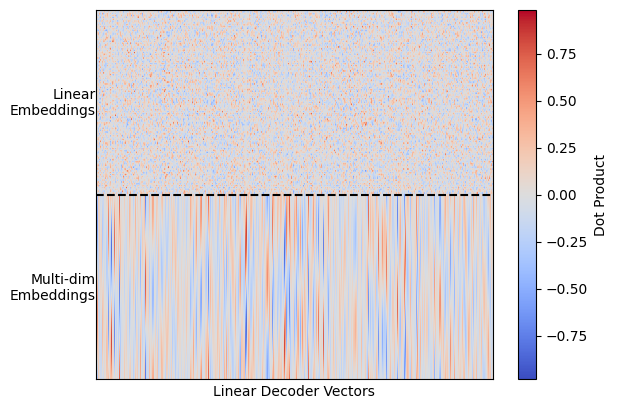

In [13]:
# %%
with centered_embeddings(
    bias=common_bias,
    linear_feature_embeddings=linear_feature_embeddings,
    multi_dim_feature_embeddings=multi_dim_feature_embeddings,
):
    # Plot the dot products between all embeddings and linear decoder vectors
    all_embeddings = torch.cat([linear_feature_embeddings, multi_dim_feature_embeddings])
    dot_products = torch.matmul(all_embeddings, sae.W_dec.T)

# Create a heatmap of the dot products
# plt.figure(figsize=(8, 6))
plt.imshow(dot_products.detach().numpy(), cmap="coolwarm", aspect="auto")
plt.colorbar(label="Dot Product")
plt.xlabel("Linear Decoder Vectors")
# plt.ylabel("Embeddings")

plt.axhline(y=linear_feature_embeddings.shape[0] - 0.5, color="black", linestyle="--")
plt.text(
    -0.5,
    linear_feature_embeddings.shape[0] / 2,
    "Linear\nEmbeddings",
    verticalalignment="center",
    horizontalalignment="right",
)

plt.text(
    -0.5,
    linear_feature_embeddings.shape[0] + multi_dim_feature_embeddings.shape[0] / 2,
    "Multi-dim\nEmbeddings",
    verticalalignment="center",
    horizontalalignment="right",
)

# remove the ticks
plt.xticks([])
plt.yticks([])
plt.show()


In [14]:
# %%
m_sae.plot_losses()


In [15]:
# %%
print(labels_l0_norm, m_sae.logs["l0_norm"].to_numpy()[-1])


1.2725000381469727 0.1784999929368496


In [16]:
# %%
linear_labels = torch.arange(linear_feature_embeddings.shape[0])
multi_labels = torch.arange(multi_dim_feature_embeddings.shape[0])

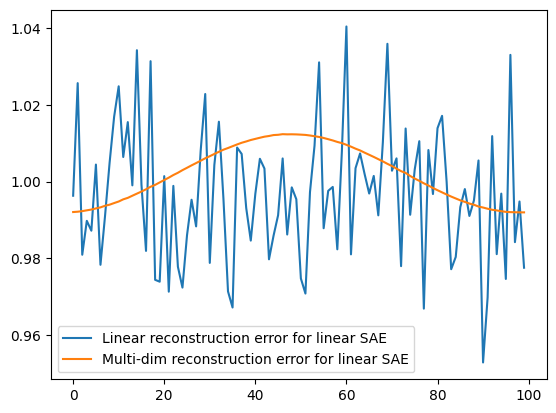

In [17]:
# %%
from utils.eval import compute_similarities



# Compute similarities for linear SAE
l_linear_similarities, l_multi_similarities = compute_similarities(
    m_sae,
    linear_feature_embeddings,
    multi_dim_feature_embeddings,
    use_linear_SAE=True,
)

# Compute similarities for multi-dim SAE
m_linear_similarities, m_multi_similarities = compute_similarities(
    m_sae,
    linear_feature_embeddings,
    multi_dim_feature_embeddings,
    use_linear_SAE=False,
)


plt.plot(l_linear_similarities, label="Linear reconstruction error for linear SAE")
plt.plot(l_multi_similarities, label="Multi-dim reconstruction error for linear SAE")
plt.legend()
plt.show()


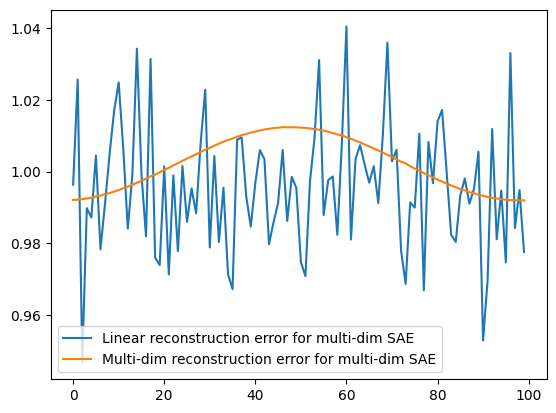

In [18]:
# %%
plt.plot(m_linear_similarities, label="Linear reconstruction error for multi-dim SAE")
plt.plot(m_multi_similarities, label="Multi-dim reconstruction error for multi-dim SAE")
plt.legend()
plt.show()


torch.Size([200, 20]) 1.0 1.0 torch.Size([200, 20])


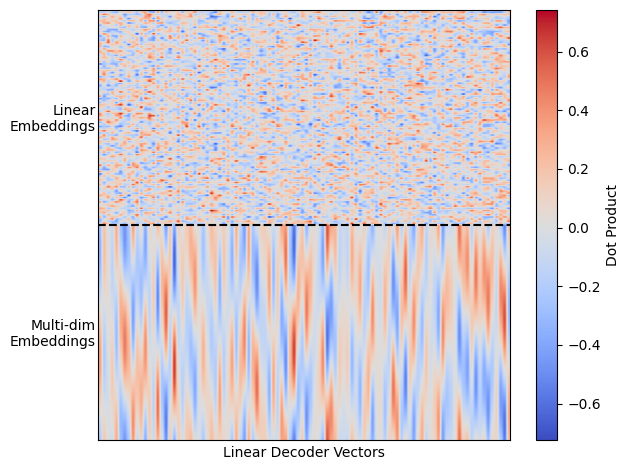

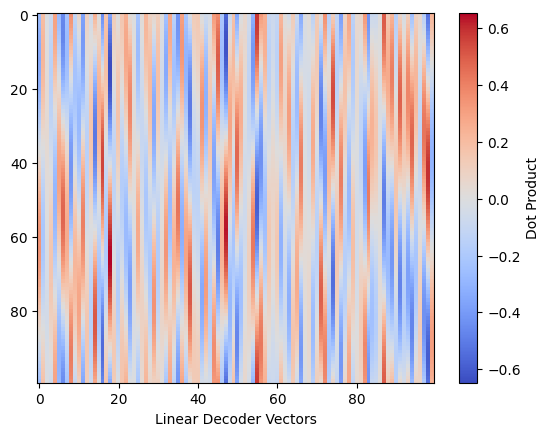

In [19]:
# %%
with centered_embeddings(
    bias=common_bias,
    linear_feature_embeddings=linear_feature_embeddings,
    multi_dim_feature_embeddings=multi_dim_feature_embeddings,
):
    all_embeddings = torch.cat([linear_feature_embeddings, multi_dim_feature_embeddings])
    all_features = torch.cat([m_sae.W_dec_multi_dim, m_sae.W_dec])
    print(
        all_features.shape,
        all_features.norm(dim=1).mean().item(),
        all_embeddings.norm(dim=1).mean().item(),
        all_embeddings.shape,
    )
    # Calculate dot products between all embeddings and linear decoder vectors
    dot_products = torch.matmul(all_embeddings, m_sae.W_dec.T)

# Create a heatmap of the dot products
# plt.figure(figsize=(10, 8))
plt.imshow(dot_products.detach().numpy(), cmap="coolwarm", aspect="auto")
plt.colorbar(label="Dot Product")
plt.xlabel("Linear Decoder Vectors")
# plt.ylabel('Embeddings')
# plt.title("Dot Products between Embeddings and Linear Decoder Vectors")

# Add labels for linear and multi-dim embeddings
plt.axhline(y=linear_feature_embeddings.shape[0] - 0.5, color="black", linestyle="--")
plt.text(
    -1,
    linear_feature_embeddings.shape[0] / 2,
    "Linear\nEmbeddings",
    verticalalignment="center",
    horizontalalignment="right",
)
plt.text(
    -1,
    linear_feature_embeddings.shape[0] + multi_dim_feature_embeddings.shape[0] / 2,
    "Multi-dim\nEmbeddings",
    verticalalignment="center",
    horizontalalignment="right",
)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

# plot the dot product between multi-dim embeddings and the linear decoder vectors
with centered_embeddings(
    bias=common_bias,
    linear_feature_embeddings=linear_feature_embeddings,
    multi_dim_feature_embeddings=multi_dim_feature_embeddings,
):
    dot_products = torch.matmul(multi_dim_feature_embeddings, m_sae.W_dec.T)

# plt.figure(figsize=(10, 8))
plt.imshow(dot_products.detach().numpy(), cmap="coolwarm", aspect="auto")
plt.colorbar(label="Dot Product")
plt.xlabel("Linear Decoder Vectors")
# plt.title("Dot Products between Multi-dim Embeddings and Linear Decoder Vectors")
plt.show()


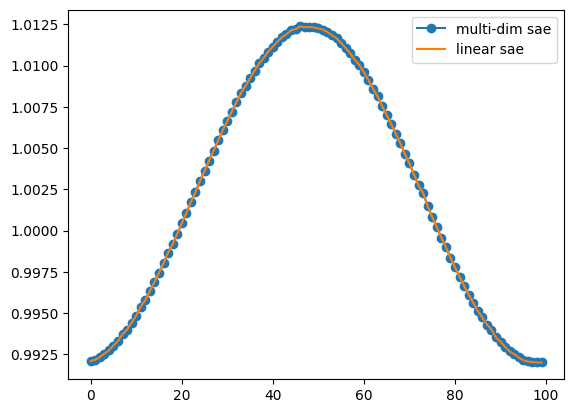

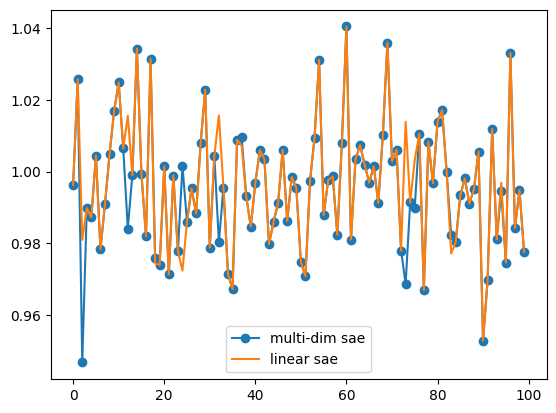

In [20]:
# %%

# plt.plot(np.array(linear_similarities) + np.array(l_linear_similarities))
# plt.plot(np.array(l_multi_similarities) + np.array(m_multi_similarities))
plt.plot(m_multi_similarities, marker="o")
plt.plot(l_multi_similarities)

plt.legend(["multi-dim sae", "linear sae"])
plt.show()

plt.plot(m_linear_similarities, marker="o")
plt.plot(l_linear_similarities)
plt.legend(["multi-dim sae", "linear sae"])
plt.show()

In [21]:
# %%
